In [18]:
%matplotlib inline

### Install Python Packages

In [19]:
# include our Python packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from tqdm import tqdm

In [20]:
torch.cuda.is_available()

False

### GPU Setup

In [21]:
if torch.cuda.is_available():
    print(torch.cuda.current_device())     # The ID of the current GPU.
    print(torch.cuda.get_device_name(id))  # The name of the specified GPU, where id is an integer.
    print(torch.cuda.device(id))           # The memory address of the specified GPU, where id is an integer.
    print(torch.cuda.device_count())
    
on_gpu = torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Get MNIST Dataset and DataLoader

In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)

test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=True)

#### View Images

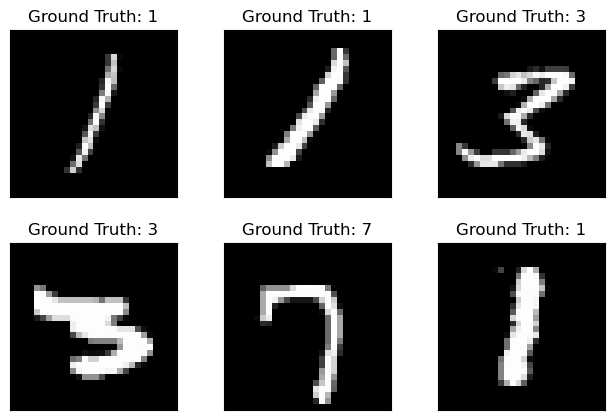

In [23]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

### Create Convolutional Nerual Net

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 40, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(160, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(self.conv3_drop(self.conv3(x)), 2)
        x = x.view(-1, 160)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x))           
        return x

### Select Model and Define HyperParameters

In [25]:
model = CNN()

print(model)

epochs = 2
learning_rate = 0.01
momentum = 0.3

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

criterion = nn.CrossEntropyLoss()

status_interval = 10

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (conv3_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=160, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


### Move Model and Data to GPU

In [26]:
if torch.cuda.is_available():
    print("Moving to Device")
    model.to(device)

### Define Training Function

In [27]:
train_loss = []
train_count = []
test_loss = []
test_count = [i*len(train_loader.dataset) for i in range(epochs + 1)]

def train(epoch, dataloader, optimizer):
    model.train()

    print(f'Train Epoch: {epoch}')

    for batch, (data, label) in tqdm(enumerate(dataloader), total=len(dataloader)):
        if on_gpu:
            data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, label)
        # loss = F.nll_loss(output, label)
        loss.backward()

        optimizer.step()

        if batch % status_interval == 0:
            # print(f'Train Epoch: {epoch} [{batch * len(data)}/{len(dataloader.dataset)}] ({batch * 100 / len(dataloader):.0f}%)\tLoss: {loss.item():.6f}')
            train_loss.append(loss.item())
            train_count.append((batch*64) + ((epoch-1)*len(dataloader.dataset)))

    print(f'Loss: {loss.item():.6f}')

### Define Training Function

In [28]:
def test(dataloader):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, label in dataloader:
            if on_gpu:
                data, label = data.to(device), label.to(device)
            output = model(data)
            loss += F.nll_loss(output, label, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(label.data.view_as(pred)).sum()
    loss /= len(dataloader.dataset)
    test_loss.append(loss)
    print(f'\nTest Set: Avg. Loss: {loss:.4f}, Accuracy: {correct}/{len(dataloader.dataset)} ({100 * correct / len(dataloader.dataset):.0f}%)')

### Train Model

In [29]:
# test(dataloader=test_loader)
for epoch in range(0, epochs):
     print('==='*30)
     train(epoch=epoch+1, dataloader=train_loader, optimizer=optimizer)
     test(dataloader=test_loader)

Train Epoch: 1


  0%|          | 0/1200 [00:00<?, ?it/s]/var/folders/4l/lh2gck1908s5qb7_dklnzyfc0000gn/T/ipykernel_15288/1103792040.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))
100%|██████████| 1200/1200 [05:05<00:00,  3.93it/s]
/Users/rchristopher/mambaforge/envs/nn/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Loss: 2.192850

Test Set: Avg. Loss: 2.1609, Accuracy: 2872/10000 (29%)
Train Epoch: 2


100%|██████████| 1200/1200 [05:14<00:00,  3.82it/s]


Loss: 0.807767

Test Set: Avg. Loss: 0.4359, Accuracy: 8734/10000 (87%)


### Test Model

In [30]:
test(test_loader)

/var/folders/4l/lh2gck1908s5qb7_dklnzyfc0000gn/T/ipykernel_15288/1103792040.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))



Test Set: Avg. Loss: 0.4359, Accuracy: 8734/10000 (87%)


### Plot Results

Text(0, 0.5, 'negative log likelihood loss')

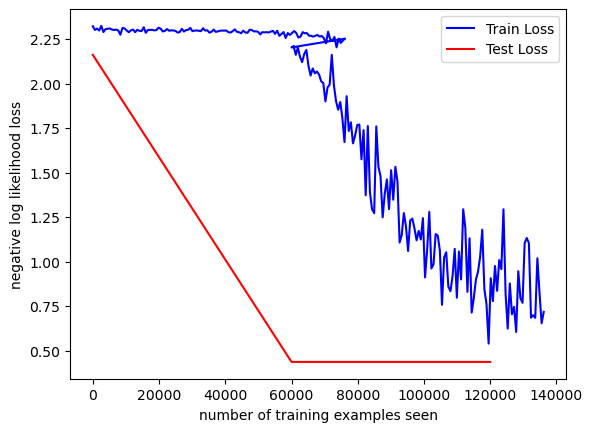

In [31]:
fig = plt.figure()
plt.plot(train_count, train_loss, color='blue')
plt.plot(test_count, test_loss, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

/var/folders/4l/lh2gck1908s5qb7_dklnzyfc0000gn/T/ipykernel_15288/1103792040.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))


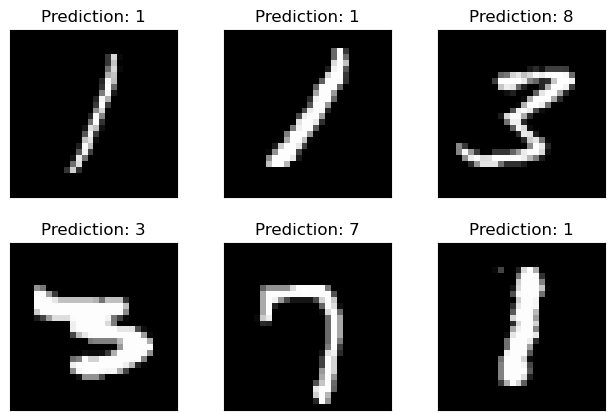

In [32]:
with torch.no_grad():
  if torch.cuda.is_available():
    model = model.to(torch.device('cpu'))
  output = model(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])